In [1]:
import os

DATA_DIRECTORY = '/home/younes'
LIVEJOURNAL_FILENAME = os.path.join(DATA_DIRECTORY, 'amazon0505.txt.gz')
LIVEJOURNAL_URL = 'http://snap.stanford.edu/data/amazon0505.txt.gz'

# Just have these hardcoded, though we don't really need to
NUM_EDGES = 3356824
NUM_NODES = 410236

In [2]:
# Downloading the file

import urllib.request

assert os.path.exists(DATA_DIRECTORY)

# Get your data. This file is ~250M so it will take a bit
print('DOWNLOADING 250M FILE. WILL SAVE FOR FUTURE USE')
if not os.path.exists(LIVEJOURNAL_FILENAME):
    urllib.request.urlretrieve(LIVEJOURNAL_URL, LIVEJOURNAL_FILENAME)

# Show a little bit of the file
print('\nFILE STATS:')
!ls -lh $LIVEJOURNAL_FILENAME
print('\nSTARTING LINES')
!zcat $LIVEJOURNAL_FILENAME | head -n 30

DOWNLOADING 250M FILE. WILL SAVE FOR FUTURE USE

FILE STATS:
-rw-rw-r-- 1 younes younes 12M ماي 19 16:17 /home/younes/amazon0505.txt.gz

STARTING LINES
# Directed graph (each unordered pair of nodes is saved once): Amazon0505.txt 
# Amazon product co-purchaisng network from May 05 2003
# Nodes: 410236 Edges: 3356824
# FromNodeId	ToNodeId
0	1
0	2
0	3
0	4
0	5
0	6
0	7
0	8
0	9
0	10
1	0
1	2
1	3
1	4
1	5
1	7
1	44
1	56
1	170
1	609
2	0
2	1
2	3
2	4
2	163
2	179

gzip: stdout: Broken pipe


In [3]:
# Cleaning the data

import numpy as np
import gzip

def row_generator():
    """This will generate all the edges in the graph."""
    with gzip.open(LIVEJOURNAL_FILENAME, 'rt') as f:
        for line in f:
            if line.startswith('#'):
                continue
            else:
                (left_node, right_node) = line.split('\t')
                yield(int(left_node), int(right_node))

def to_undirected(edge_iterable, num_edges, num_nodes, shuffle=True):
    """Takes an iterable of edges and produces the list of edges for the undirected graph.
    
    > to_undirected([[0,1],[1,2],[2,10]], 3, 11)
    array([[ 0,  1],
       [ 1,  0],
       [ 1,  2],
       [ 2,  1],
       [ 2, 10],
       [10,  2]])
    """
    # need int64 to do gross bithacks
    as_array = np.zeros((num_edges, 2), dtype=np.int64)
    for (i, (n_0, n_1)) in enumerate(edge_iterable):
            as_array[i,0] = n_0
            as_array[i,1] = n_1
    # The graph is directed, but we want to make it undirected,
    # which means we will duplicate some rows.

    left_nodes = as_array[:,0]
    right_nodes = as_array[:,1]
    
    if shuffle:
        the_shuffle = np.arange(num_nodes)
        np.random.shuffle(the_shuffle)
        left_nodes = the_shuffle.take(left_nodes)
        right_nodes = the_shuffle.take(right_nodes)

    
    # numpy.unique will not unique whole rows, so this little bit-hacking
    # is a quick way to get unique rows after making a flipped copy of
    # each edge.
    max_bits = int(np.ceil(np.log2(num_nodes + 1)))
    
    encoded_edges_forward = np.left_shift(left_nodes, max_bits) | right_nodes
    
    # Flip the columns and do it again:
    encoded_edges_reverse = np.left_shift(right_nodes, max_bits) | left_nodes

    unique_encoded_edges = np.unique(np.hstack((encoded_edges_forward, encoded_edges_reverse)))
    
    left_node_decoded = np.right_shift(unique_encoded_edges, max_bits)
    
    # Mask out the high order bits
    right_node_decoded = (2 ** (max_bits) - 1) & unique_encoded_edges
    
    undirected_edges = np.vstack((left_node_decoded, right_node_decoded)).T.astype(np.int32)

    # ascontiguousarray so that it's c-contiguous for cython code below
    return np.ascontiguousarray(undirected_edges)


def get_clean_data(shuffle=True):
    if shuffle:
        name = os.path.join(DATA_DIRECTORY, 'LJ-ak-shuffled.npy')
    else:
        name = os.path.join(DATA_DIRECTORY, 'LJ-ak.npy')

    if os.path.exists(name):
        print('Loading from file {}'.format(name))
        return np.load(name)
    else:
        print('Parsing from zip. Will write to file {}'.format(name), flush=True)
        # Lets get the edges into one big array
        edges = to_undirected(row_generator(), NUM_EDGES, NUM_NODES, shuffle=shuffle)
        print('ORIGINAL DIST: {} MIN: {} MAX: {}'.format(np.abs(edges[:,0] - edges[:,1]).mean(), edges.min(), edges.max()))
        np.save(name, edges)
        return edges

In [4]:
print("Normalizing data (or loaded pre-computed)")
%time edges = get_clean_data(shuffle=True)
%time unshuffled_edges = get_clean_data(shuffle=False)
print('\nEDGES SHAPE: {}'.format(edges.shape))

Normalizing data (or loaded pre-computed)
Loading from file /home/younes/LJ-ak-shuffled.npy
CPU times: user 145 µs, sys: 34.9 ms, total: 35 ms
Wall time: 1.03 s
Loading from file /home/younes/LJ-ak.npy
CPU times: user 18.5 ms, sys: 23.4 ms, total: 41.9 ms
Wall time: 624 ms

EDGES SHAPE: (4878874, 2)


In [5]:
%load_ext cython
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [6]:
def score(assignment, edges):
    """Compute the score given an assignment of vertices.
    
    N nodes are assigned to clusters 0 to K-1.
    
    assignment: Vector where N[i] is the cluster node i is assigned to.
    edges: The edges in the graph, assumed to have one in each direction
    
    Returns: (total wasted bin space, ratio of edges cut)
    """
    balance = np.bincount(assignment) / len(assignment)
    waste = (np.max(balance) - balance).sum()
    
    left_edge_assignment = assignment.take(edges[:,0])
    right_edge_assignment = assignment.take(edges[:,1])
    mismatch = (left_edge_assignment != right_edge_assignment).sum()
    cut_ratio = mismatch / len(edges)
    return (waste, cut_ratio)

In [34]:
%%cython
import numpy as np
cimport cython

cdef int UNMAPPED = -1

def linear_deterministic_greedy(int[:,::] edges,
                                int num_nodes,
                                int num_partitions,
                                int[::] partition):
    """
    This algorithm favors a cluster if it has many neighbors of a node, but
    penalizes the cluster if it is close to capacity.
    
    edges: An [:,2] array of edges.
    num_nodes: The number of nodes in the graph.
    num_partitions: How many partitions we are breaking the graph into.
    partition: The partition from a previous run. Used for restreaming.

    Returns: A new partition.
    """
    # The output partition

    if partition is None:
        partition = np.repeat(np.int32(UNMAPPED), num_nodes)

    cdef int[::] partition_sizes = np.zeros(num_partitions, dtype=np.int32)
         
    cdef int[::] partition_votes = np.zeros(num_partitions, dtype=np.int32)
    
    # Fine to be a little off, to stay integers
    cdef int partition_capacity = num_nodes / num_partitions
    
    cdef int last_left = edges[0,0]
    cdef int i = 0
    cdef int left = 0
    cdef int right = 0
    cdef int arg = 0
    cdef int max_arg = 0
    cdef int max_val = 0
    cdef int val = 0
    cdef int len_edges = len(edges)
    
    for i in range(len_edges):
        left = edges[i,0]
        right = edges[i,1]
    
        if last_left != left:
            # We have found a new node so assign last_left to a partition
                
            max_arg = 0
            max_val = (partition_votes[0]) * (
                       partition_capacity - partition_sizes[0])

            for arg in range(1, num_partitions):
                val = (partition_votes[arg]) * (
                       partition_capacity - partition_sizes[arg])
                if val > max_val:
                    max_arg = arg
                    max_val = val

            if max_val == 0:
                max_arg = arg
                # No neighbors (or multiple maxed out) so "randomly" select
                # the smallest partition
                for arg in range(i % num_partitions, num_partitions):
                    if partition_sizes[arg] < partition_capacity:
                        max_arg = arg
                        max_val = 1
                        break
                if max_val == 0:
                    for arg in range(0, i % num_partitions):
                        if partition_sizes[arg] < partition_capacity:
                            max_arg = arg
                            break


            partition_sizes[max_arg] += 1
            partition[last_left] = max_arg
            partition_votes[:] = 0
            last_left = left

        if partition[right] != UNMAPPED:
            partition_votes[partition[right]] += 1


    # Clean up the last assignment
    max_arg = 0
    max_val = 0
    for arg in range(0, num_partitions):
        if partition_sizes[arg] < partition_capacity:
            val = (partition_votes[arg]) * (
                    1 - partition_sizes[arg] / partition_capacity)
            if val > max_val:
                max_arg = arg
                max_val = val
    partition[left] = max_arg

    return np.asarray(partition)

In [8]:
assignments = None
%time partition = linear_deterministic_greedy(edges, NUM_NODES, 2, assignments)
(waste, edge_score) = score(partition, edges)
print("edge score:"+str(edge_score)+" waste: "+str(waste))

CPU times: user 77.9 ms, sys: 0 ns, total: 77.9 ms
Wall time: 77.5 ms
edge score:0.20448324756900876 waste: 0.0


In [9]:
assignments = None
%time partition = linear_deterministic_greedy(edges, NUM_NODES, 4, assignments)
(waste, edge_score) = score(partition, edges)
print("edge score:"+str(edge_score)+" waste: "+str(waste))

CPU times: user 82.7 ms, sys: 0 ns, total: 82.7 ms
Wall time: 82.1 ms
edge score:0.31869894569935603 waste: 0.0


In [10]:
assignments = None
%time partition = linear_deterministic_greedy(edges, NUM_NODES, 8, assignments)
(waste, edge_score) = score(partition, edges)
print("edge score:"+str(edge_score)+" waste: "+str(waste))

CPU times: user 81.2 ms, sys: 6.29 ms, total: 87.5 ms
Wall time: 87.2 ms
edge score:0.3832412970697747 waste: 4.8752425433146174e-05


In [11]:
assignments = None
%time partition = linear_deterministic_greedy(edges, NUM_NODES, 16, assignments)
(waste, edge_score) = score(partition, edges)
print("edge score:"+str(edge_score)+" waste: "+str(waste))

CPU times: user 86.4 ms, sys: 510 µs, total: 86.9 ms
Wall time: 86.3 ms
edge score:0.4193024865983422 waste: 0.00039976988855204565


In [12]:
assignments = None
%time partition = linear_deterministic_greedy(edges, NUM_NODES, 32, assignments)
(waste, edge_score) = score(partition, edges)
print("edge score:"+str(edge_score)+" waste: "+str(waste))

CPU times: user 110 ms, sys: 3.47 ms, total: 114 ms
Wall time: 113 ms
edge score:0.43545662380295125 waste: 0.0020378513831063247


In [13]:
assignments = None
%time partition = linear_deterministic_greedy(edges, NUM_NODES, 40, assignments)
(waste, edge_score) = score(partition, edges)
print("edge score:"+str(edge_score)+" waste: "+str(waste))

CPU times: user 111 ms, sys: 3.61 ms, total: 114 ms
Wall time: 114 ms
edge score:0.43883896161286395 waste: 0.0033249154145417875


In [35]:
def draw_figures(waste_values, edge_score_values, num_partitions):
    fig, axes = plt.subplots(nrows=1, ncols=2)
    
    (waste_axes, score_axes) = axes
    waste_axes.plot(waste_values, 'r')
    waste_axes.set_xlabel('Round')
    waste_axes.set_ylabel('Number of wasted bins')
    waste_axes.set_ylim(bottom=0)
    waste_axes.set_title('Wasted Bins: {} partitions'.format(num_partitions))
    
    score_axes.plot(edge_score_values, 'r')
    score_axes.set_xlabel('Round')
    score_axes.set_ylabel('Edge Cut')
    score_axes.set_ylim(bottom=0)
    score_axes.set_title('Score: {} partitions'.format(num_partitions))
 
    fig.tight_layout()

In [36]:
def run_restreaming_greedy(edges, num_nodes, num_partitions=10, num_iterations=10):
    print('\n{} PARTITIONS'.format(num_partitions))
    assignments = None
    print('ROUND\tWASTE\tSCORE')
    waste_values = []
    edge_score_values = []
    flipped_edges = numpy.flipud(edges).copy()
    for i in range(num_iterations):
        assignments = linear_deterministic_greedy(edges, NUM_NODES, num_partitions, assignments)
        (waste, edge_score) = score(assignments, edges)
        waste_values.append(waste)
        edge_score_values.append(edge_score)
        print('{}\t{:0.3f}\t{:0.3f}'.format(i, waste, edge_score))
    draw_figures(waste_values, edge_score_values, num_partitions)


2 PARTITIONS
ROUND	WASTE	SCORE
0	0.000	0.204
1	0.000	0.146
2	0.000	0.131
3	0.000	0.125
4	0.000	0.122
5	0.000	0.120
6	0.000	0.119
7	0.000	0.118
8	0.000	0.117
9	0.000	0.117
10	0.000	0.116
11	0.000	0.116
12	0.000	0.116
13	0.000	0.116
14	0.000	0.116
15	0.000	0.116
16	0.000	0.116
17	0.000	0.116
18	0.000	0.116
19	0.000	0.116
CPU times: user 2.23 s, sys: 714 ms, total: 2.95 s
Wall time: 2.81 s


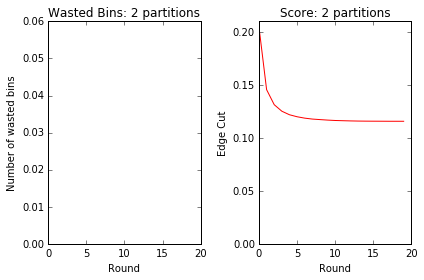

In [18]:
%time run_restreaming_greedy(edges, NUM_NODES, num_partitions=2, num_iterations=20)



4 PARTITIONS
ROUND	WASTE	SCORE
0	0.000	0.319
1	0.000	0.230
2	0.000	0.208
3	0.000	0.199
4	0.000	0.195
5	0.000	0.192
6	0.000	0.190
7	0.000	0.189
8	0.000	0.188
9	0.000	0.188
10	0.000	0.187
11	0.000	0.187
12	0.000	0.187
13	0.000	0.187
14	0.000	0.187
15	0.000	0.186
16	0.000	0.186
17	0.000	0.186
18	0.000	0.186
19	0.000	0.186
CPU times: user 2.18 s, sys: 747 ms, total: 2.92 s
Wall time: 2.75 s


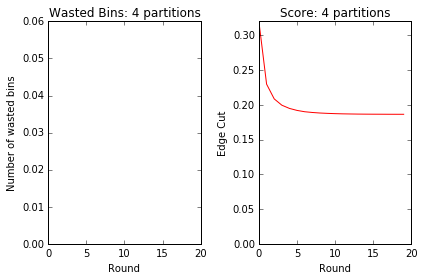

In [19]:
%time run_restreaming_greedy(edges, NUM_NODES, num_partitions=4, num_iterations=20)



8 PARTITIONS
ROUND	WASTE	SCORE
0	0.000	0.383
1	0.000	0.282
2	0.000	0.257
3	0.000	0.247
4	0.000	0.240
5	0.000	0.236
6	0.000	0.234
7	0.000	0.232
8	0.000	0.230
9	0.000	0.230
10	0.000	0.229
11	0.000	0.229
12	0.000	0.228
13	0.000	0.228
14	0.000	0.228
15	0.000	0.228
16	0.000	0.228
17	0.000	0.228
18	0.000	0.228
19	0.000	0.227
CPU times: user 2.25 s, sys: 760 ms, total: 3.01 s
Wall time: 2.87 s


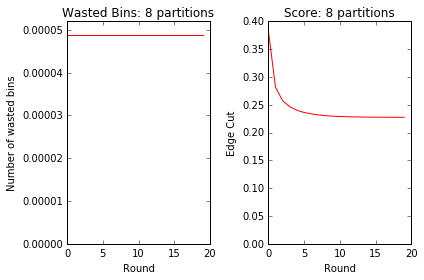

In [20]:
%time run_restreaming_greedy(edges, NUM_NODES, num_partitions=8, num_iterations=20)



16 PARTITIONS
ROUND	WASTE	SCORE
0	0.000	0.419
1	0.000	0.311
2	0.000	0.287
3	0.000	0.276
4	0.000	0.270
5	0.000	0.266
6	0.000	0.264
7	0.000	0.262
8	0.000	0.261
9	0.000	0.260
10	0.000	0.259
11	0.000	0.259
12	0.000	0.259
13	0.000	0.258
14	0.000	0.258
15	0.000	0.258
16	0.000	0.258
17	0.000	0.258
18	0.000	0.258
19	0.000	0.258
CPU times: user 2.66 s, sys: 759 ms, total: 3.42 s
Wall time: 3.26 s


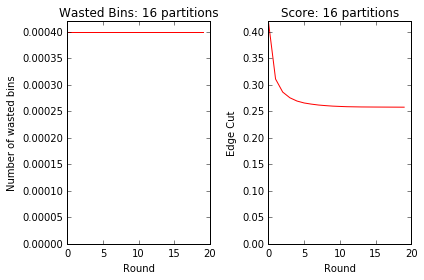

In [21]:
%time run_restreaming_greedy(edges, NUM_NODES, num_partitions=16, num_iterations=20)



32 PARTITIONS
ROUND	WASTE	SCORE
0	0.002	0.435
1	0.002	0.323
2	0.002	0.298
3	0.002	0.287
4	0.002	0.281
5	0.002	0.278
6	0.002	0.276
7	0.002	0.274
8	0.002	0.273
9	0.002	0.273
10	0.002	0.272
11	0.002	0.272
12	0.002	0.272
13	0.002	0.271
14	0.002	0.271
15	0.002	0.271
16	0.002	0.271
17	0.002	0.271
18	0.002	0.271
19	0.002	0.271
CPU times: user 2.87 s, sys: 755 ms, total: 3.62 s
Wall time: 3.51 s


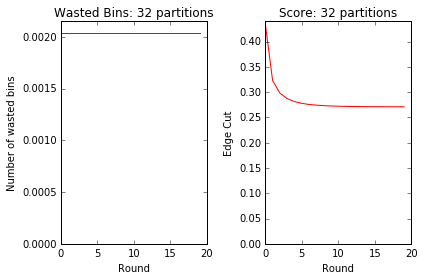

In [22]:
%time run_restreaming_greedy(edges, NUM_NODES, num_partitions=32, num_iterations=20)



40 PARTITIONS
ROUND	WASTE	SCORE
0	0.003	0.439
1	0.003	0.327
2	0.003	0.304
3	0.003	0.293
4	0.003	0.287
5	0.003	0.283
6	0.003	0.281
7	0.003	0.279
8	0.003	0.278
9	0.003	0.277
10	0.003	0.277
11	0.003	0.276
12	0.003	0.276
13	0.003	0.276
14	0.003	0.275
15	0.003	0.275
16	0.003	0.275
17	0.003	0.275
18	0.003	0.275
19	0.003	0.275
CPU times: user 3.54 s, sys: 791 ms, total: 4.33 s
Wall time: 4.18 s


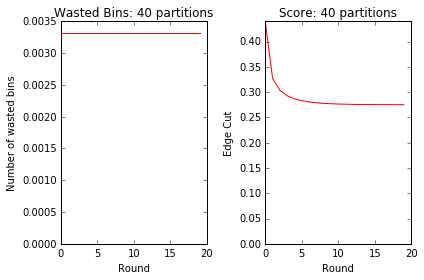

In [23]:
%time run_restreaming_greedy(edges, NUM_NODES, num_partitions=40, num_iterations=20)


In [24]:
%%cython
import numpy as np

cdef int UNMAPPED = -1

def fennel(int[:,::] edges,
           int num_nodes,
           int num_partitions,
           int[::] partition,
           float alpha):
    """
    This algorithm favors a cluster if it has many neighbors of a node, but
    penalizes the cluster if it is close to capacity.
    
    partition: A previous partition of the nodes. Set to -1's if a node has not been assigned.
    """
    
    cdef int[::] partition_sizes = None
    # The output partition
    if partition is None:
        partition = np.repeat(np.int32(UNMAPPED), num_nodes)
        partition_sizes = np.zeros(num_partitions, dtype=np.int32)
    else:
        partition_sizes = np.bincount(partition).astype(np.int32)
    
    cdef int[::] partition_votes = np.zeros(num_partitions, dtype=np.int32)
    
    cdef float partition_capacity = num_nodes / num_partitions
    
    cdef int last_left = edges[0,0]
    cdef int i = 0
    cdef int left = 0
    cdef int right = 0
    cdef int arg = 0
    cdef int max_arg = 0
    cdef float max_val = 0
    cdef float val = 0
    cdef int len_edges = len(edges)
    cdef int previous_assignment = 0

    for i in range(len_edges):
        left = edges[i,0]
        right = edges[i,1]
    
        if last_left != left:
            # New left node, so we have to assign last left

            # Remember placement of last_left in the previous assignment
            previous_assignment = partition[last_left]
            
            max_arg = 0
            max_val = partition_votes[0] - alpha * partition_sizes[0]
            if previous_assignment == 0:
                # We remove the node from its current partition before
                # deciding to re-add it, so subtract alpha to give
                # result of 1 lower partition size.
                max_val += alpha

            for arg in range(1, num_partitions):
                val = partition_votes[arg] - alpha * partition_sizes[arg]
                if previous_assignment == arg:
                    # See comment above
                    val += alpha
                if val > max_val:
                    max_arg = arg
                    max_val = val

            if max_arg != previous_assignment:
                partition[last_left] = max_arg
                partition_sizes[max_arg] += 1
                if previous_assignment != UNMAPPED:
                    partition_sizes[previous_assignment] -= 1

            partition_votes[:] = 0
            last_left = left

        if partition[right] != -1:
            partition_votes[partition[right]] += 1
    
    # TODO: finish off this fencepost....
    partition[left] = 0
    
    return np.asarray(partition)

In [24]:
assignment = None
%time assignment = fennel(edges,NUM_NODES,2,assignment,1.)
%time wast,edge_cut = score(assignment, edges)
print('wast='+str(1+wast)+' edge cut = '+str(edge_cut))

CPU times: user 109 ms, sys: 467 µs, total: 109 ms
Wall time: 109 ms
CPU times: user 52.7 ms, sys: 36.2 ms, total: 89 ms
Wall time: 87.8 ms
wast=1.0000097504850867 edge cut = 0.24124008941407382


In [25]:
assignment = None
%time assignment = fennel(edges,NUM_NODES,2,assignment,1.00000015)
%time wast,edge_cut = score(assignment, edges)
print('wast='+str(1+wast)+' edge cut = '+str(edge_cut))

CPU times: user 141 ms, sys: 660 µs, total: 142 ms
Wall time: 142 ms
CPU times: user 59.7 ms, sys: 28.6 ms, total: 88.3 ms
Wall time: 86.8 ms
wast=1.0000097504850867 edge cut = 0.24118556863735363


In [32]:
assignment = None
%time assignment = fennel(edges,NUM_NODES,4,assignment,1.)
%time wast,edge_cut = score(assignment, edges)
print('wast='+str(1+wast)+' edge cut = '+str(edge_cut))

CPU times: user 100 ms, sys: 1.59 ms, total: 102 ms
Wall time: 103 ms
CPU times: user 59.8 ms, sys: 28.3 ms, total: 88.1 ms
Wall time: 86.9 ms
wast=1.0000195009701733 edge cut = 0.37612941018767854


In [33]:
assignment = None
%time assignment = fennel(edges,NUM_NODES,8,assignment,1.)
%time wast,edge_cut = score(assignment, edges)
print('wast='+str(1+wast)+' edge cut = '+str(edge_cut))

CPU times: user 116 ms, sys: 145 µs, total: 116 ms
Wall time: 116 ms
CPU times: user 42.4 ms, sys: 43.3 ms, total: 85.7 ms
Wall time: 84.1 ms
wast=1.00002925145526 edge cut = 0.4500079321581168


In [34]:
assignment = None
%time assignment = fennel(edges,NUM_NODES,16,assignment,1.)
%time wast,edge_cut = score(assignment, edges)
print('wast='+str(1+wast)+' edge cut = '+str(edge_cut))

CPU times: user 112 ms, sys: 0 ns, total: 112 ms
Wall time: 112 ms
CPU times: user 51.4 ms, sys: 39.1 ms, total: 90.5 ms
Wall time: 89.3 ms
wast=1.0000877543657798 edge cut = 0.49148184601610945


In [35]:
assignment = None
%time assignment = fennel(edges,NUM_NODES,32,assignment,1.)
%time wast,edge_cut = score(assignment, edges)
print('wast='+str(1+wast)+' edge cut = '+str(edge_cut))

CPU times: user 136 ms, sys: 231 µs, total: 137 ms
Wall time: 136 ms
CPU times: user 47.5 ms, sys: 39.8 ms, total: 87.3 ms
Wall time: 86 ms
wast=1.0001657582464727 edge cut = 0.5135984245545181


In [36]:
assignment = None
%time assignment = fennel(edges,NUM_NODES,40,assignment,1.)
%time wast,edge_cut = score(assignment, edges)
print('wast='+str(1+wast)+' edge cut = '+str(edge_cut))

CPU times: user 146 ms, sys: 0 ns, total: 146 ms
Wall time: 146 ms
CPU times: user 54.4 ms, sys: 34.7 ms, total: 89.1 ms
Wall time: 87.3 ms
wast=1.0002047601868194 edge cut = 0.5195083947648577


In [27]:
def run_fennel_restreaming(edges, num_nodes, num_partitions, num_iterations):
    print('{} PARTITIONS'.format(num_partitions))
    assignments = None
    # We will explore this parameter in a future post. This is sub-optimal
    alphas = np.linspace(1.251608191745264e-07, 7.588951557309824e-02, num_iterations)
    waste_scores, edge_score_values = [], []
    print('ROUND\tALPHA\tWASTE\tSCORE')
    for i in range(num_iterations):
        alpha = alphas[i]
        assignments = fennel(edges, NUM_NODES, num_partitions, assignments, 1.)
        (waste, edge_score) = score(assignments, edges)
        print('{}\t{:.1e}\t{:0.3f}\t{:0.3f}'.format(i, alpha, waste, edge_score))
        waste_scores.append(waste)
        edge_score_values.append(edge_score)
    draw_figures(waste_scores, edge_score_values, num_partitions)

# K = 2

2 PARTITIONS
ROUND	ALPHA	WASTE	SCORE
0	1.3e-07	0.000	0.241
1	4.1e-06	0.000	0.165
2	8.1e-06	0.000	0.145
3	1.2e-05	0.000	0.136
4	1.6e-05	0.000	0.130
5	2.0e-05	0.000	0.126
6	2.4e-05	0.000	0.124
7	2.8e-05	0.000	0.122
8	3.2e-05	0.000	0.121
9	3.6e-05	0.000	0.120
10	4.0e-05	0.000	0.119
11	4.4e-05	0.000	0.118
12	4.8e-05	0.000	0.118
13	5.2e-05	0.000	0.117
14	5.6e-05	0.000	0.117
15	6.0e-05	0.000	0.116
16	6.4e-05	0.000	0.116
17	6.8e-05	0.000	0.116
18	7.2e-05	0.000	0.115
19	7.6e-05	0.000	0.115
CPU times: user 3.01 s, sys: 722 ms, total: 3.73 s
Wall time: 3.61 s


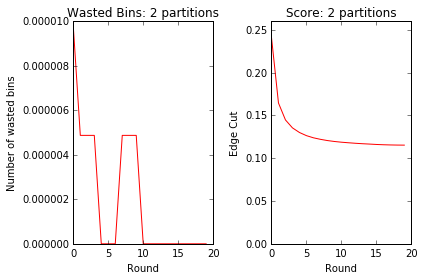

In [26]:
%time run_fennel_restreaming(edges, NUM_NODES, 2, 20)


2 PARTITIONS
ROUND	ALPHA	WASTE	SCORE
0	1.3e-07	0.000	0.241
1	4.0e-03	0.000	0.165
2	8.0e-03	0.000	0.145
3	1.2e-02	0.000	0.136
4	1.6e-02	0.000	0.130
5	2.0e-02	0.000	0.126
6	2.4e-02	0.000	0.124
7	2.8e-02	0.000	0.122
8	3.2e-02	0.000	0.121
9	3.6e-02	0.000	0.120
10	4.0e-02	0.000	0.119
11	4.4e-02	0.000	0.118
12	4.8e-02	0.000	0.118
13	5.2e-02	0.000	0.117
14	5.6e-02	0.000	0.117
15	6.0e-02	0.000	0.116
16	6.4e-02	0.000	0.116
17	6.8e-02	0.000	0.116
18	7.2e-02	0.000	0.115
19	7.6e-02	0.000	0.115
CPU times: user 3.61 s, sys: 848 ms, total: 4.46 s
Wall time: 4.34 s


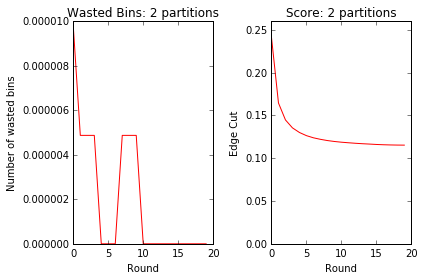

In [28]:
%time run_fennel_restreaming(edges, NUM_NODES, 2, 20)


# K=4

4 PARTITIONS
ROUND	ALPHA	WASTE	SCORE
0	1.3e-07	0.000	0.376
1	2.7e-06	0.000	0.262
2	5.4e-06	0.000	0.231
3	8.0e-06	0.000	0.217
4	1.1e-05	0.000	0.209
5	1.3e-05	0.000	0.204
6	1.6e-05	0.000	0.200
7	1.8e-05	0.000	0.197
8	2.1e-05	0.000	0.195
9	2.4e-05	0.000	0.194
10	2.6e-05	0.000	0.192
11	2.9e-05	0.000	0.191
12	3.1e-05	0.000	0.190
13	3.4e-05	0.000	0.190
14	3.7e-05	0.000	0.189
15	3.9e-05	0.000	0.188
16	4.2e-05	0.000	0.188
17	4.5e-05	0.000	0.187
18	4.7e-05	0.000	0.187
19	5.0e-05	0.000	0.187
20	5.2e-05	0.000	0.186
21	5.5e-05	0.000	0.186
22	5.8e-05	0.000	0.186
23	6.0e-05	0.000	0.186
24	6.3e-05	0.000	0.186
25	6.5e-05	0.000	0.185
26	6.8e-05	0.000	0.185
27	7.1e-05	0.000	0.185
28	7.3e-05	0.000	0.185
29	7.6e-05	0.000	0.185
CPU times: user 4.77 s, sys: 1.1 s, total: 5.86 s
Wall time: 5.71 s


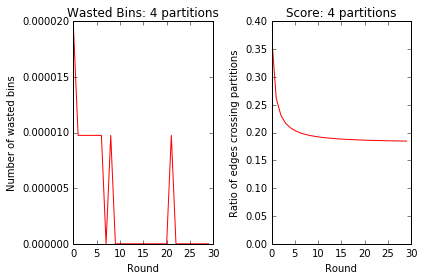

In [41]:
%time run_fennel_restreaming(edges, NUM_NODES, 4, 20)


8 PARTITIONS
ROUND	ALPHA	WASTE	SCORE
0	1.3e-07	0.000	0.450
1	4.0e-03	0.000	0.316
2	8.0e-03	0.000	0.280
3	1.2e-02	0.000	0.264
4	1.6e-02	0.000	0.255
5	2.0e-02	0.000	0.248
6	2.4e-02	0.000	0.243
7	2.8e-02	0.000	0.240
8	3.2e-02	0.000	0.237
9	3.6e-02	0.000	0.235
10	4.0e-02	0.000	0.233
11	4.4e-02	0.000	0.232
12	4.8e-02	0.000	0.230
13	5.2e-02	0.000	0.229
14	5.6e-02	0.000	0.228
15	6.0e-02	0.000	0.228
16	6.4e-02	0.000	0.227
17	6.8e-02	0.000	0.226
18	7.2e-02	0.000	0.226
19	7.6e-02	0.000	0.225
CPU times: user 3.15 s, sys: 789 ms, total: 3.94 s
Wall time: 3.82 s


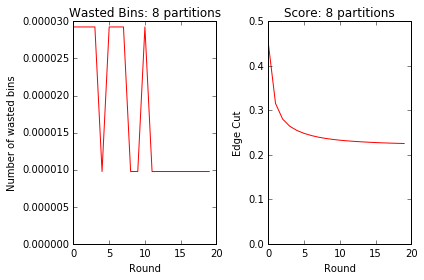

In [37]:
%time run_fennel_restreaming(edges, NUM_NODES, 8, 20)


16 PARTITIONS
ROUND	ALPHA	WASTE	SCORE
0	1.3e-07	0.000	0.491
1	4.0e-03	0.000	0.349
2	8.0e-03	0.000	0.313
3	1.2e-02	0.000	0.297
4	1.6e-02	0.000	0.288
5	2.0e-02	0.000	0.281
6	2.4e-02	0.000	0.277
7	2.8e-02	0.000	0.274
8	3.2e-02	0.000	0.271
9	3.6e-02	0.000	0.269
10	4.0e-02	0.000	0.267
11	4.4e-02	0.000	0.266
12	4.8e-02	0.000	0.264
13	5.2e-02	0.000	0.263
14	5.6e-02	0.000	0.262
15	6.0e-02	0.000	0.262
16	6.4e-02	0.000	0.261
17	6.8e-02	0.000	0.260
18	7.2e-02	0.000	0.260
19	7.6e-02	0.000	0.259
CPU times: user 4.61 s, sys: 847 ms, total: 5.46 s
Wall time: 5.31 s


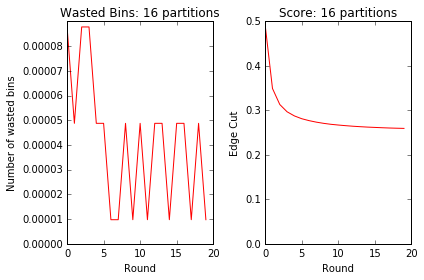

In [38]:
%time run_fennel_restreaming(edges, NUM_NODES, 16, 20)


32 PARTITIONS
ROUND	ALPHA	WASTE	SCORE
0	1.3e-07	0.000	0.514
1	4.0e-03	0.000	0.366
2	8.0e-03	0.000	0.329
3	1.2e-02	0.000	0.313
4	1.6e-02	0.000	0.303
5	2.0e-02	0.000	0.296
6	2.4e-02	0.000	0.292
7	2.8e-02	0.000	0.288
8	3.2e-02	0.000	0.286
9	3.6e-02	0.000	0.284
10	4.0e-02	0.000	0.282
11	4.4e-02	0.000	0.281
12	4.8e-02	0.000	0.279
13	5.2e-02	0.000	0.278
14	5.6e-02	0.000	0.277
15	6.0e-02	0.000	0.276
16	6.4e-02	0.000	0.276
17	6.8e-02	0.000	0.275
18	7.2e-02	0.000	0.275
19	7.6e-02	0.000	0.274
CPU times: user 4.25 s, sys: 754 ms, total: 5 s
Wall time: 4.87 s


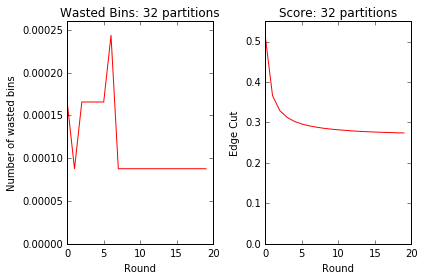

In [39]:
%time run_fennel_restreaming(edges, NUM_NODES, 32, 20)


40 PARTITIONS
ROUND	ALPHA	WASTE	SCORE
0	1.3e-07	0.000	0.520
1	4.0e-03	0.000	0.372
2	8.0e-03	0.000	0.336
3	1.2e-02	0.000	0.320
4	1.6e-02	0.000	0.310
5	2.0e-02	0.000	0.304
6	2.4e-02	0.000	0.299
7	2.8e-02	0.000	0.296
8	3.2e-02	0.000	0.294
9	3.6e-02	0.000	0.292
10	4.0e-02	0.000	0.290
11	4.4e-02	0.000	0.289
12	4.8e-02	0.000	0.288
13	5.2e-02	0.000	0.286
14	5.6e-02	0.000	0.286
15	6.0e-02	0.000	0.285
16	6.4e-02	0.000	0.284
17	6.8e-02	0.000	0.284
18	7.2e-02	0.000	0.283
19	7.6e-02	0.000	0.283
CPU times: user 4.07 s, sys: 732 ms, total: 4.8 s
Wall time: 4.71 s


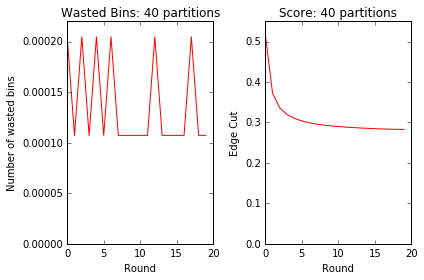

In [40]:
%time run_fennel_restreaming(edges, NUM_NODES, 40, 20)
